# 3. Machine Learning for Classification

We'll use logistic regression to predict churn


## 3.1 Churn prediction project

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


## 3.2 Data preparation

* Download the data, read it with pandas
* Look at the data
* Make column names and values look uniform
* Check if all the columns read correctly
* Check if the churn variable needs any preparation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [3]:
!wget $data -O data-week-3.csv 

--2024-08-10 10:25:38--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘data-week-3.csv’

data-week-3.csv     100%[===================>] 954.59K  5.80MB/s    in 0.2s    

2024-08-10 10:25:39 (5.80 MB/s) - ‘data-week-3.csv’ saved [977501/977501]



In [4]:
df = pd.read_csv('data-week-3.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [6]:
df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [7]:
tc = pd.to_numeric(df.totalcharges, errors='coerce')

In [8]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

In [9]:
df.totalcharges = df.totalcharges.fillna(0)

In [10]:
df.churn.head()

0     no
1     no
2    yes
3     no
4    yes
Name: churn, dtype: object

In [11]:
df.churn = (df.churn == 'yes').astype(int)

## 3.3 Setting up the validation framework

* Perform the train/validation/test split with Scikit-Learn

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [14]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

## 3.4 EDA

* Check missing values
* Look at the target variable (churn)
* Look at numerical and categorical variables

In [17]:
df_full_train = df_full_train.reset_index(drop=True)

In [18]:
df_full_train.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [19]:
df_full_train.churn.value_counts(normalize=True)

0    0.730032
1    0.269968
Name: churn, dtype: float64

In [20]:
df_full_train.churn.mean()

0.26996805111821087

In [21]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [22]:
categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [23]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

## 3.5 Feature importance: Churn rate and risk ratio

Feature importance analysis (part of EDA) - identifying which features affect our target variable

* Churn rate
* Risk ratio
* Mutual information - later

#### Churn rate

In [24]:
df_full_train.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0


In [25]:
churn_female = df_full_train[df_full_train.gender == 'female'].churn.mean()
churn_female

0.27682403433476394

In [26]:
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()
churn_male

0.2632135306553911

In [27]:
global_churn = df_full_train.churn.mean()
global_churn

0.26996805111821087

In [28]:
global_churn - churn_female

-0.006855983216553063

In [29]:
global_churn - churn_male

0.006754520462819769

In [30]:
df_full_train.partner.value_counts()

no     2932
yes    2702
Name: partner, dtype: int64

In [31]:
churn_partner = df_full_train[df_full_train.partner == 'yes'].churn.mean()
churn_partner

0.20503330866025166

In [32]:
global_churn - churn_partner

0.06493474245795922

In [33]:
churn_no_partner = df_full_train[df_full_train.partner == 'no'].churn.mean()
churn_no_partner

0.3298090040927694

In [34]:
global_churn - churn_no_partner

-0.05984095297455855

#### Risk ratio

In [35]:
churn_no_partner / global_churn

1.2216593879412643

In [36]:
churn_partner / global_churn

0.7594724924338315

```
SELECT
    gender,
    AVG(churn),
    AVG(churn) - global_churn AS diff,
    AVG(churn) / global_churn AS risk
FROM
    data
GROUP BY
    gender;
```

In [37]:
from IPython.display import display

In [38]:
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)
    print()
    print()

gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980




seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208




partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472




dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651




phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412




multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948




internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201




onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570




onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660




deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480




techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390




streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328




streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182




contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730




paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560




paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


## 3.6 Feature importance: Mutual information

Mutual information - concept from information theory, it tells us how much 
we can learn about one variable if we know the value of another

* https://en.wikipedia.org/wiki/Mutual_information

In [39]:
from sklearn.metrics import mutual_info_score

In [40]:
mutual_info_score(df_full_train.churn, df_full_train.contract)

0.0983203874041556

In [41]:
mutual_info_score(df_full_train.gender, df_full_train.churn)

0.0001174846211139946

In [42]:
mutual_info_score(df_full_train.contract, df_full_train.churn)

0.0983203874041556

In [43]:
mutual_info_score(df_full_train.partner, df_full_train.churn)

0.009967689095399745

In [44]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [45]:
mi = df_full_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

## 3.7 Feature importance: Correlation

How about numerical columns?

* Correlation coefficient - https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

In [46]:
df_full_train.tenure.max()

72

In [47]:
df_full_train[numerical].corrwith(df_full_train.churn).abs()

tenure            0.351885
monthlycharges    0.196805
totalcharges      0.196353
dtype: float64

In [48]:
df_full_train[df_full_train.tenure <= 2].churn.mean()

0.5953420669577875

In [49]:
df_full_train[(df_full_train.tenure > 2) & (df_full_train.tenure <= 12)].churn.mean()

0.3994413407821229

In [50]:
df_full_train[df_full_train.tenure > 12].churn.mean()

0.17634908339788277

In [51]:
df_full_train[df_full_train.monthlycharges <= 20].churn.mean()

0.08795411089866156

In [52]:
df_full_train[(df_full_train.monthlycharges > 20) & (df_full_train.monthlycharges <= 50)].churn.mean()

0.18340943683409436

In [53]:
df_full_train[df_full_train.monthlycharges > 50].churn.mean()

0.32499341585462205

## 3.8 One-hot encoding

* Use Scikit-Learn to encode categorical features

In [54]:
from sklearn.feature_extraction import DictVectorizer

In [55]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [106]:
len(categorical), len(numerical)

(16, 3)

## 3.9 Logistic regression

* Binary classification
* Linear vs logistic regression

In [56]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [57]:
z = np.linspace(-7, 7, 51)

In [58]:
sigmoid(10000)

1.0

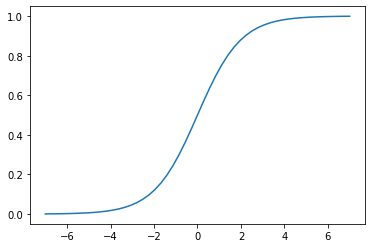

In [59]:
plt.plot(z, sigmoid(z))

In [60]:
def linear_regression(xi):
    result = w0
    
    for j in range(len(w)):
        result = result + xi[j] * w[j]
        
    return result

In [61]:
def logistic_regression(xi):
    score = w0
    
    for j in range(len(w)):
        score = score + xi[j] * w[j]
        
    result = sigmoid(score)
    return result

## 3.10 Training logistic regression with Scikit-Learn

* Train a model with Scikit-Learn
* Apply it to the validation dataset
* Calculate the accuracy

In [62]:
from sklearn.linear_model import LogisticRegression

In [103]:
X_train.shape

(4225, 45)

In [63]:
model = LogisticRegression(solver='lbfgs')
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_train, y_train)

LogisticRegression()

In [64]:
model.intercept_[0]

-0.10903336331773535

In [65]:
model.coef_[0].round(3)

array([ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.316, -0.089,  0.004, -0.258,  0.141,
        0.009,  0.063, -0.089, -0.081,  0.266, -0.089, -0.284, -0.231,
        0.124, -0.166,  0.058, -0.087, -0.032,  0.07 , -0.059,  0.141,
       -0.249,  0.215, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.07 ,  0.   ])

In [66]:
y_pred = model.predict_proba(X_val)[:, 1]

In [67]:
churn_decision = (y_pred >= 0.5)

In [68]:
(y_val == churn_decision).mean()

0.8034066713981547

In [69]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val

In [70]:
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [71]:
df_pred.correct.mean()

0.8034066713981547

In [72]:
churn_decision.astype(int)

array([0, 0, 0, ..., 0, 1, 1])

## 3.11 Model interpretation

* Look at the coefficients
* Train a smaller model with fewer features

In [73]:
a = [1, 2, 3, 4]
b = 'abcd'

In [74]:
dict(zip(a, b))

{1: 'a', 2: 'b', 3: 'c', 4: 'd'}

In [75]:
dict(zip(dv.get_feature_names(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.475,
 'contract=one_year': -0.175,
 'contract=two_year': -0.408,
 'dependents=no': -0.03,
 'dependents=yes': -0.078,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.089,
 'deviceprotection=yes': -0.081,
 'gender=female': -0.034,
 'gender=male': -0.073,
 'internetservice=dsl': -0.335,
 'internetservice=fiber_optic': 0.316,
 'internetservice=no': -0.089,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.258,
 'multiplelines=no_phone_service': 0.141,
 'multiplelines=yes': 0.009,
 'onlinebackup=no': 0.063,
 'onlinebackup=no_internet_service': -0.089,
 'onlinebackup=yes': -0.081,
 'onlinesecurity=no': 0.266,
 'onlinesecurity=no_internet_service': -0.089,
 'onlinesecurity=yes': -0.284,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.124,
 'partner=no': -0.166,
 'partner=yes': 0.058,
 'paymentmethod=bank_transfer_(automatic)': -0.087,
 'paymentmethod=credit_card_(automatic)': -0.032,
 'paymentmethod=electronic_check': 0.07,
 

In [76]:
small = ['contract', 'tenure', 'monthlycharges']

In [77]:
df_train[small].iloc[:10].to_dict(orient='records')

[{'contract': 'two_year', 'tenure': 72, 'monthlycharges': 115.5},
 {'contract': 'month-to-month', 'tenure': 10, 'monthlycharges': 95.25},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 75.55},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 80.85},
 {'contract': 'two_year', 'tenure': 18, 'monthlycharges': 20.1},
 {'contract': 'month-to-month', 'tenure': 4, 'monthlycharges': 30.5},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 75.1},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 70.3},
 {'contract': 'two_year', 'tenure': 72, 'monthlycharges': 19.75},
 {'contract': 'month-to-month', 'tenure': 6, 'monthlycharges': 109.9}]

In [78]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')

In [79]:
dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

DictVectorizer(sparse=False)

In [80]:
dv_small.get_feature_names()

['contract=month-to-month',
 'contract=one_year',
 'contract=two_year',
 'monthlycharges',
 'tenure']

In [81]:
X_train_small = dv_small.transform(dicts_train_small)

In [82]:
model_small = LogisticRegression(solver='lbfgs')
model_small.fit(X_train_small, y_train)

LogisticRegression()

In [83]:
w0 = model_small.intercept_[0]
w0

-2.4767756625266997

In [84]:
w = model_small.coef_[0]
w.round(3)

array([ 0.97 , -0.025, -0.949,  0.027, -0.036])

In [85]:
dict(zip(dv_small.get_feature_names(), w.round(3)))

{'contract=month-to-month': 0.97,
 'contract=one_year': -0.025,
 'contract=two_year': -0.949,
 'monthlycharges': 0.027,
 'tenure': -0.036}

In [86]:
-2.47 + (-0.949) + 30 * 0.027 + 24 * (-0.036)

-3.473

In [87]:
sigmoid(_)

0.030090303318277657

## 3.12 Using the model

In [88]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

In [89]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [90]:
y_full_train = df_full_train.churn.values

In [91]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_full_train, y_full_train)

LogisticRegression()

In [92]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')

In [93]:
X_test = dv.transform(dicts_test)

In [94]:
y_pred = model.predict_proba(X_test)[:, 1]

In [95]:
churn_decision = (y_pred >= 0.5)

In [96]:
(churn_decision == y_test).mean()

0.815471965933286

In [97]:
y_test

array([0, 0, 0, ..., 0, 0, 1])

In [98]:
customer = dicts_test[-1]
customer

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 17,
 'monthlycharges': 104.2,
 'totalcharges': 1743.5}

In [99]:
X_small = dv.transform([customer])

In [100]:
model.predict_proba(X_small)[0, 1]

0.5968852088274386

In [101]:
y_test[-1]

1

## 3.13 Summary

* Feature importance - risk, mutual information, correlation
* One-hot encoding can be implemented with `DictVectorizer`
* Logistic regression - linear model like linear regression
* Output of log reg - probability
* Interpretation of weights is similar to linear regression

## 3.14 Explore more

More things

* Try to exclude least useful features


Use scikit-learn in project of last week

* Re-implement train/val/test split using scikit-learn in the project from the last week
* Also, instead of our own linear regression, use `LinearRegression` (not regularized) and `RidgeRegression` (regularized). Find the best regularization parameter for Ridge

Other projects

* Lead scoring - https://www.kaggle.com/ashydv/leads-dataset
* Default prediction - https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

